## Data Preparation<a class="anchor" id="data_preparation"></a>

In [1]:
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,InputLayer,Reshape,Conv2DTranspose
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np
import tensorflow as tf

import imgaug as ia
import imgaug.augmenters as iaa
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.metrics import accuracy_score

tf.get_logger().setLevel(3)
import cv2
import os, glob
import pandas as pd

In [2]:
DATASET_PATH = r"./dataset/"
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42
dataset_folders = []  # to keep main folder names
total = 0
print(f"There are {len(os.listdir(DATASET_PATH))} folder in dataset.")
for path in sorted(os.listdir(DATASET_PATH)):
    print(f"\t-There are {len(os.listdir(DATASET_PATH + path))} images in {path} folder.")
    total += len(os.listdir(DATASET_PATH + path))  # add element size of the current folder to total variable
    dataset_folders.append(DATASET_PATH + path)  # add current folder path to dataset_folders

# Create an empty dataframe
df = pd.DataFrame(0,
                  columns=['paths',
                           'class_label'],
                  index=range(total))
# store each image path in the dataframe
# class labels -> 0:Normal 1:Cataract 2:Glaucoma 3:RetinaDisease
i = 0
for p, path in enumerate(dataset_folders):  # main folders
    for sub_path in sorted(os.listdir(path)):  #images
        df.iloc[i, 0] = path + "/" + sub_path
        df.iloc[i, 1] = p
        i += 1
# Display some examples for the created DataFrame
# print(df.sample(frac=1, random_state=SEED).head(10))
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['class_label'])

There are 4 folder in dataset.
	-There are 300 images in 1_normal folder.
	-There are 100 images in 2_cataract folder.
	-There are 101 images in 2_glaucoma folder.
	-There are 100 images in 3_retina_disease folder.


In [3]:
example_paths = [DATASET_PATH + "1_normal/NL_001.png", DATASET_PATH + "2_cataract/cataract_001.png",
                 DATASET_PATH + "2_glaucoma/Glaucoma_001.png", DATASET_PATH + "3_retina_disease/Retina_001.png"]
images_array1 = []
images_array2 = []


def display_examples(images_array1, images_array2, row1, row2, channel=3):
    fig = plt.figure(figsize=(15, 9))
    plt.title(f"First row->{row1} Images    Second row->{row2} Images")
    plt.axis('off')
    plt.grid(False)
    for i in range(4):
        current_path = example_paths[i]

        fig.add_subplot(2, 4, i + 1)
        plt.axis('off')
        plt.title(current_path.split("/")[3])
        plt.imshow(images_array1[i])

        fig.add_subplot(2, 4, i + 5)
        plt.axis('off')
        plt.title(current_path.split("/")[3])
        if channel == 1:
            plt.imshow(images_array2[i], cmap='gray')
        else:
            plt.imshow(images_array2[i])

## Initial preprocess
Our first preprocessing method is applied in every iteration since the outcome is the stripping of unnecessary data.

In this preprocess, we delete unnecessary black areas from the images. Also we resize the images to 128x128 due to huge dimensions and to feed our model with a standard image shape.


In [4]:
#Cropping image to avoid from unnecessary black areas
def deleteBlackAreas(filename):
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    img = cv2.imread(filename)  #read image from file
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # turn it into a binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # find contours
    if len(contours) != 0:
        #find the biggest area
        cnt = max(contours, key=cv2.contourArea)

        #find the bounding rect
        x, y, w, h = cv2.boundingRect(cnt)

        crop = img[y:y + h, x:x + w]  # crop image
        crop1 = cv2.cvtColor(cv2.resize(crop, image_size, interpolation=cv2.INTER_AREA),
                             cv2.COLOR_BGR2RGB)  # resize to image_size and change color space from BGR to RGB for matplotlib
        return crop1
    else:
        return cv2.cvtColor(cv2.resize(img, image_size, interpolation=cv2.INTER_AREA), cv2.COLOR_BGR2RGB)

## Create Dataset and Augmentation Functions

In [5]:
def create_dataset(df):
    # Creating dataset
    images = []
    labels = []
    index = 0
    for path in tqdm(df['paths']):
        #According to parameter, we apply some preprocesses here. default=0
        img = deleteBlackAreas(path)  #deleting black areas. Initial preprocess
        label = [0, 0, 0, 0]
        label[df.iloc[index]["class_label"]] += 1
        index += 1
        images.append(img)
        labels.append(label)
    images = np.array(images, dtype='float32') / 255
    labels = np.array(labels)
    return augmentation(images, labels)

def augmentation(images, labels):
    ia.seed(42)
    crop = iaa.Sequential([
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        iaa.Crop(percent=(0, 0.15))
    ])

    contrast = iaa.Sequential([
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        iaa.LinearContrast((0.75, 1.5)),
    ])

    mix = iaa.Sequential([
        iaa.Sometimes(
            0.5,
            iaa.Crop(percent=(0, 0.1)),  # random crops
        ),
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        iaa.Sometimes(
            0.5,
            iaa.LinearContrast((0.75, 1.5)),
        ),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-4, 4)
        )
    ], random_order=True)  # apply augmenters in random order

    augmentation_dict = {0: contrast, 1: mix }
    images_result = None
    labels_result = None
    seeds = [6, 37]
    for i in range(len(augmentation_dict)):
        func = augmentation_dict[i]
        if i == 0:
            images_augmented = func(images=images)
            images_result = np.concatenate((images, images_augmented))
            labels_result = np.concatenate((labels, labels))
        elif i == 3:
            for k in range(2):
                ia.seed(seeds[k])
                images_augmented = func(images=images)
                images_result = np.concatenate((images_result, images_augmented))
                labels_result = np.concatenate((labels_result, labels))
        else:
            images_augmented = func(images=images)
            images_result = np.concatenate((images_result, images_augmented))
            labels_result = np.concatenate((labels_result, labels))
    return images_result, labels_result

In [6]:
# Creating dataset and split the data
train_images, train_labels = create_dataset(train_df)
test_images, test_labels = create_dataset(test_df)
labels = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]


100%|██████████| 121/121 [00:09<00:00, 12.94it/s]


In [7]:
X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels

In [8]:
print(f"X train shape -> {X_train.shape}")
print(f"X test shape -> {X_test.shape}")
print(f"Y train shape -> {np.array(y_train).shape}")
print(f"Y test shape -> {np.array(y_test).shape}")

X train shape -> (1440, 128, 128, 3)
X test shape -> (363, 128, 128, 3)
Y train shape -> (1440, 4)
Y test shape -> (363, 4)


In [9]:
def mahal(img, select=None, mean_pix=None):
    arr = np.reshape(img, (img.shape[0] * img.shape[1], 3))
    # no sampling.  use the entire image
    if select is None:
        select = arr
    else:
        # if 'select' is a number, generate an array of size 'select' containing
        # random pixels in 'arr'.
        # otherwise it should be a list of indices of pixels to choose.
        select = arr[np.random.randint(0, arr.shape[0], select), :] if isinstance(select, int) else arr[select]

    # calculate the covariance matrix inverse using the sampled array
    invcovar = np.linalg.inv(np.cov(np.transpose(select)))

    if mean_pix is None:
        # no provided mean RGB vector.  assume we are using the images own
        # mean RGB value
        meandiff = arr - np.mean(select, axis=0)
    else:
        meandiff = arr - mean_pix

    # calculate the difference between every pixel in 'arr' and the mean RGB vector.
    # if provided, use the given mean RGB vector, otherwise calculate the mean RGB
    # value of 'select'
    meandiff = arr - (mean_pix if mean_pix is not None else np.mean(select, axis=0))

    # calculate the first multiplication.
    output = np.dot(meandiff, invcovar)

    # do literally everything else all in this step, then reshape back to image dimensions and return
    return np.sqrt(np.einsum('ij,ij->i', output, meandiff)).reshape(img.shape[:-1])


def amplify(image, mask, cutoff=0):
    mask_modf = np.greater(mask * 100.0 / np.amax(mask), cutoff) * mask

    # apply mask
    output = np.einsum('ij,ijk->ijk', mask_modf, image) / np.amax(mask_modf)

    # scale to 255 (2^8 - 1 = unsigned 8-bit max)
    output *= (255.0 / np.amax(image))

    return np.uint8(output)

for i in range(4):
    img = deleteBlackAreas(example_paths[i])
    images_array1.append(img)
    img2 = mahal(img)
    images_array2.append(img2)
display_examples(images_array1, images_array2, "Normal", "MAHAL")
images_array1.clear()
images_array2.clear()

train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)
indexes_train = [0, 0, 0, 0]
indexes_test = [0, 0, 0, 0]
label_map = {0: "normal", 1: "cataract", 2: "glaucoma", 3: "retina_disease"}
for i in range(len(X_train)):
    length = len(str(indexes_train[train_labels[i]]))
    file_name = (4 - length) * "0" + str(indexes_train[train_labels[i]]) + ".png"
    to_path = r"./train/" + label_map[train_labels[i]] + "/" + file_name
    cv2.imwrite(to_path, cv2.cvtColor(X_train[i], cv2.COLOR_RGB2BGR))
    indexes_train[train_labels[i]] += 1

for i in range(len(X_test)):
    length = len(str(indexes_test[test_labels[i]]))
    file_name = (4 - length) * "0" + str(indexes_test[test_labels[i]]) + ".png"
    to_path = r"./test/" + label_map[test_labels[i]] + "/" + file_name
    cv2.imwrite(to_path, cv2.cvtColor(X_test[i], cv2.COLOR_RGB2BGR))
    indexes_test[test_labels[i]] += 1

print(indexes_train, " ---> ", np.sum(indexes_train))
print(indexes_test, " ---> ", np.sum(indexes_test))

In [10]:
encoding_dim= 1024
encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(128, 128, 3)),
        Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
        Flatten(),
        Dense(encoding_dim, )
    ])
print(encoder_net.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 512)       1049088   
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
Total params: 135,402,176
Trainable params: 135,402,176
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
dense_dim=[16,16,512]
decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(encoding_dim,)),
        Dense(np.prod(dense_dim)),
        Reshape(target_shape=dense_dim),
        Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
    ])
print(decoder_net.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 131072)            134348800 
                                                                 
 reshape (Reshape)           (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      2097408   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 3)      3075      
 ranspose)                                                       
                                                      

In [12]:
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

od = OutlierVAE(
    threshold=0.15,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=1024,
    samples=4
)

In [13]:
adam=tf.keras.optimizers.Adam(lr=1e-4)
od.fit(X_train,
       optimizer=adam,
       epochs=10,
       batch_size=64,
       verbose=True)

23/23 [=] - 72s 3s/step - loss_ma: -48862.5836


In [14]:
od.infer_threshold(X_test,outlier_type='instance',threshold_perc=99.0)
print("Current th: ", od.threshold)

Current th:  0.025523610934615106


In [15]:
od_preds_test=od.predict(X_test,
                    outlier_type='instance',
                    return_feature_score=True,
                    return_instance_score=True
                    )

In [16]:
print(list(od_preds_test['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


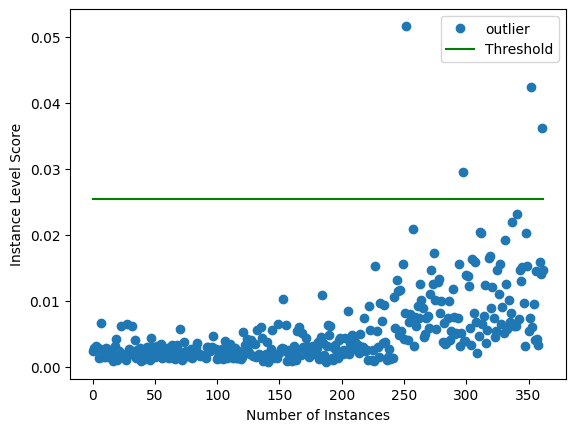

In [17]:
target = np.ones(X_test.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds_test, target, labels, od.threshold) #pred, target, labels, threshold

In [23]:
outlier_indexes_test=[]
for i in range(len(X_test)):
    if od_preds_test['data']['instance_score'][i] > od.threshold:
        outlier_indexes_test.append(i)
print("Outlier indexes: ",outlier_indexes_test)

Outlier indexes:  [252, 297, 352, 361]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


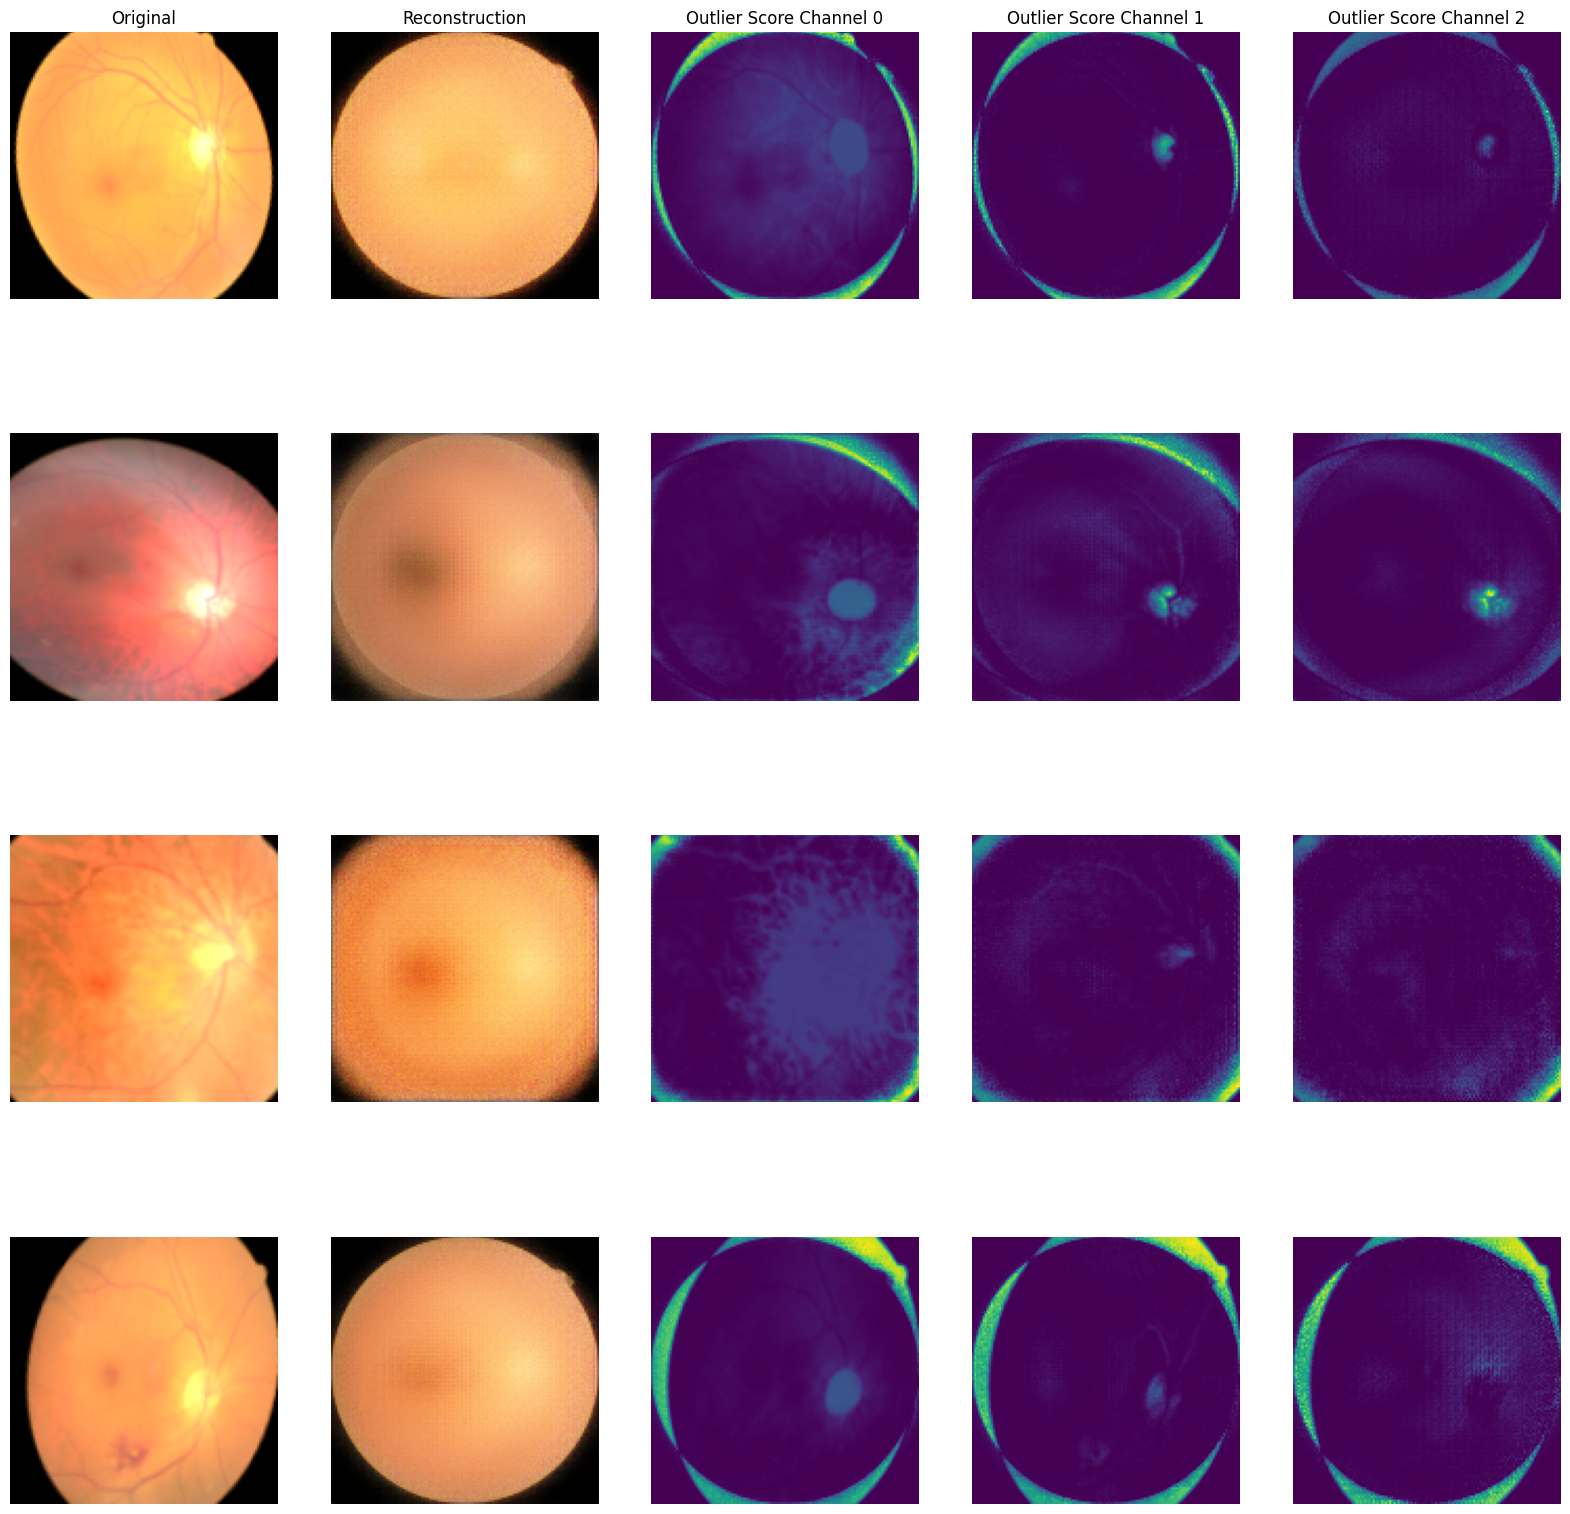

In [24]:
if len(outlier_indexes_test) !=0:
    #Plot features for select images, using the built in function (plot_feature_outlier_image)
    X_recon = od.vae(X_test).numpy()
    plot_feature_outlier_image(od_preds_test,
                               X_test,
                               X_recon=X_recon,
                               instance_ids=outlier_indexes_test,  # pass a list with indices of instances to display
                               max_instances=5,  # max nb of instances to display
                               outliers_only=False)  # only show outlier predictions

od_preds_train=od.predict(X_train,
                    outlier_type='instance',
                    return_feature_score=True,
                    return_instance_score=True
                    )

print(list(od_preds_train['data'].keys()))